In [1]:

import pickle
import numpy as np
import pandas as pd 
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import joblib



In [2]:
demand = pd.read_csv("demand_hourly.csv")
tss = TimeSeriesSplit(n_splits=5, test_size=24*60, gap=24)
df = demand.sort_values(by=['start_time_year', 'start_time_month', 
                            'start_time_day', 'start_time_hour'])
df = df.drop(columns=['Unnamed: 0', 'duration_sec']).reset_index(drop=True)

standard_stations = pd.read_csv("stations_with_clusters.csv")
weather_data = pd.read_csv("weather_data.csv")

df = df.merge(standard_stations[['station_name', 'clusters']].rename(columns={
    "station_name":'start_station_name'}), on=["start_station_name"])

df = df[df.groupby('start_station_name')['start_station_name'].transform('size') >= 1000]

latest_trips = df.groupby('start_station_name').nth(-1)
earliest_trips = df.groupby('start_station_name').nth(0)


recently_operational_stations = latest_trips[(latest_trips['start_time_year'] == 2022) & 
                                             (latest_trips['start_time_month'] >= 8)].index

stations_operational_since_2021 = earliest_trips[(earliest_trips['start_time_year'] == 2021)].index
df = df[df['start_station_name'].isin(stations_operational_since_2021)].reset_index(drop=True)

column_name = "start_time"
conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day'],
                           hour=  df[f'{column_name}_hour']
                        )
df['time'] = pd.to_datetime(conversion_dict_daily).astype(str)

df = df.merge(weather_data[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'time']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "time"])

df.loc[df['prcp'].isna(), 'prcp'] = 0.0
df.loc[df['pres'].isna(), 'pres'] = df['pres'].median()
df.loc[df['coco'].isna(), 'coco'] = df['coco'].mode()[0]

In [3]:
df = df[df['start_time_year'] == 2022].reset_index(drop=True)

In [4]:
def add_lags(df, target, identifier):
    df_res = pd.DataFrame()
    print(target)
    for ii in df[identifier].unique():
        df_current = df[df["start_station_name"]==ii]
        df_current.index = df_current['time']
        df_current.index = pd.to_datetime(df_current.index)
        target_map = df_current[target].to_dict()
        df_current[f"{target}_lag_1_h"] = (df_current.index - pd.Timedelta('1 hours')).map(target_map)
        df_current[f"{target}_lag_2_h"] = (df_current.index - pd.Timedelta('2 hours')).map(target_map)
        df_current[f"{target}_lag_24_h"] = (df_current.index - pd.Timedelta('24 hours')).map(target_map)
        if target == "demand":
            df_current[f"{target}_lag_1_h"] = df_current[f"{target}_lag_1_h"].fillna(0)
            df_current[f"{target}_lag_2_h"] = df_current[f"{target}_lag_2_h"].fillna(0)
            df_current[f"{target}_lag_24_h"] = df_current[f"{target}_lag_24_h"].fillna(0)
        else:
            df_current[f"{target}_lag_1_h"] = df_current[f"{target}_lag_1_h"].interpolate().fillna(0)
            df_current[f"{target}_lag_2_h"] = df_current[f"{target}_lag_2_h"].interpolate().fillna(0)
            df_current[f"{target}_lag_24_h"] = df_current[f"{target}_lag_24_h"].interpolate().fillna(0)
        df_res = df_res.append(df_current)
    return df_res

In [5]:
df = add_lags(df, "demand", identifier='start_station_name')
df = add_lags(df, "temp", identifier='start_station_name')
df = add_lags(df, "prcp", identifier='start_station_name')
df = add_lags(df, "rhum", identifier='start_station_name')
df = add_lags(df, "wspd", identifier='start_station_name')

df = df.sort_values(by=['start_time_year', 'start_time_month', 
                        'start_time_day', 'start_time_hour']).drop(
    columns=['time']).reset_index(drop=True)

demand


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

temp


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

prcp
rhum
wspd


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040322 entries, 0 to 1040321
Data columns (total 34 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   start_station_name    1040322 non-null  object 
 1   start_time_year       1040322 non-null  int64  
 2   start_time_month      1040322 non-null  int64  
 3   start_time_day        1040322 non-null  int64  
 4   start_time_hour       1040322 non-null  int64  
 5   demand                1040322 non-null  int64  
 6   start_time_week       1040322 non-null  int64  
 7   start_time_quarter    1040322 non-null  int64  
 8   start_time_dayofweek  1040322 non-null  int64  
 9   is_holiday            1040322 non-null  bool   
 10  clusters              1040322 non-null  int64  
 11  temp                  1040322 non-null  float64
 12  dwpt                  1040322 non-null  float64
 13  rhum                  1040322 non-null  float64
 14  prcp                  1040322 non-

In [7]:
for i in df.columns:
    if 'lag' in i:
        print((df[(df['start_station_name'] == "1st St at Folsom St")][i].interpolate().isna()))

0          False
233        False
356        False
412        False
986        False
           ...  
1039960    False
1040009    False
1040046    False
1040204    False
1040266    False
Name: demand_lag_1_h, Length: 5051, dtype: bool
0          False
233        False
356        False
412        False
986        False
           ...  
1039960    False
1040009    False
1040046    False
1040204    False
1040266    False
Name: demand_lag_2_h, Length: 5051, dtype: bool
0          False
233        False
356        False
412        False
986        False
           ...  
1039960    False
1040009    False
1040046    False
1040204    False
1040266    False
Name: demand_lag_24_h, Length: 5051, dtype: bool
0          False
233        False
356        False
412        False
986        False
           ...  
1039960    False
1040009    False
1040046    False
1040204    False
1040266    False
Name: temp_lag_1_h, Length: 5051, dtype: bool
0          False
233        False
356        False
412       

In [8]:
for i in df.columns:
    print(i)
    print(sum(df[i].isna()))

start_station_name
0
start_time_year
0
start_time_month
0
start_time_day
0
start_time_hour
0
demand
0
start_time_week
0
start_time_quarter
0
start_time_dayofweek
0
is_holiday
0
clusters
0
temp
0
dwpt
0
rhum
0
prcp
0
wdir
0
wspd
0
pres
0
coco
0
demand_lag_1_h
0
demand_lag_2_h
0
demand_lag_24_h
0
temp_lag_1_h
0
temp_lag_2_h
0
temp_lag_24_h
0
prcp_lag_1_h
0
prcp_lag_2_h
0
prcp_lag_24_h
0
rhum_lag_1_h
0
rhum_lag_2_h
0
rhum_lag_24_h
0
wspd_lag_1_h
0
wspd_lag_2_h
0
wspd_lag_24_h
0


In [9]:
del demand

In [10]:
df.tail()

,start_station_name,start_time_year,start_time_month,start_time_day,start_time_hour,demand,start_time_week,start_time_quarter,start_time_dayofweek,is_holiday,...,temp_lag_24_h,prcp_lag_1_h,prcp_lag_2_h,prcp_lag_24_h,rhum_lag_1_h,rhum_lag_2_h,rhum_lag_24_h,wspd_lag_1_h,wspd_lag_2_h,wspd_lag_24_h
1040317,24th St at Bartlett St,2022,12,31,23,1,52,4,5,True,...,17.200,13.9,7.95,0.5,89.0,95.250000,84.00,24.10,2.350000,35.300
1040318,Irving St at 18th Ave,2022,12,31,23,1,52,4,5,True,...,8.284,0.0,0.00,0.0,45.5,84.071429,66.88,3.25,9.914286,11.952
1040319,Telegraph Ave at 49th St,2022,12,31,23,1,52,4,5,True,...,15.600,0.0,0.00,0.0,51.0,81.000000,78.00,22.30,9.400000,7.600
1040320,Almaden Blvd at San Fernando St,2022,12,31,23,1,52,4,5,True,...,18.300,0.0,0.00,0.0,79.0,86.000000,39.00,4.00,5.400000,14.800
1040321,San Pedro Square,2022,12,31,23,1,52,4,5,True,...,17.000,0.0,0.00,0.0,82.0,66.000000,75.00,4.70,14.800000,22.000


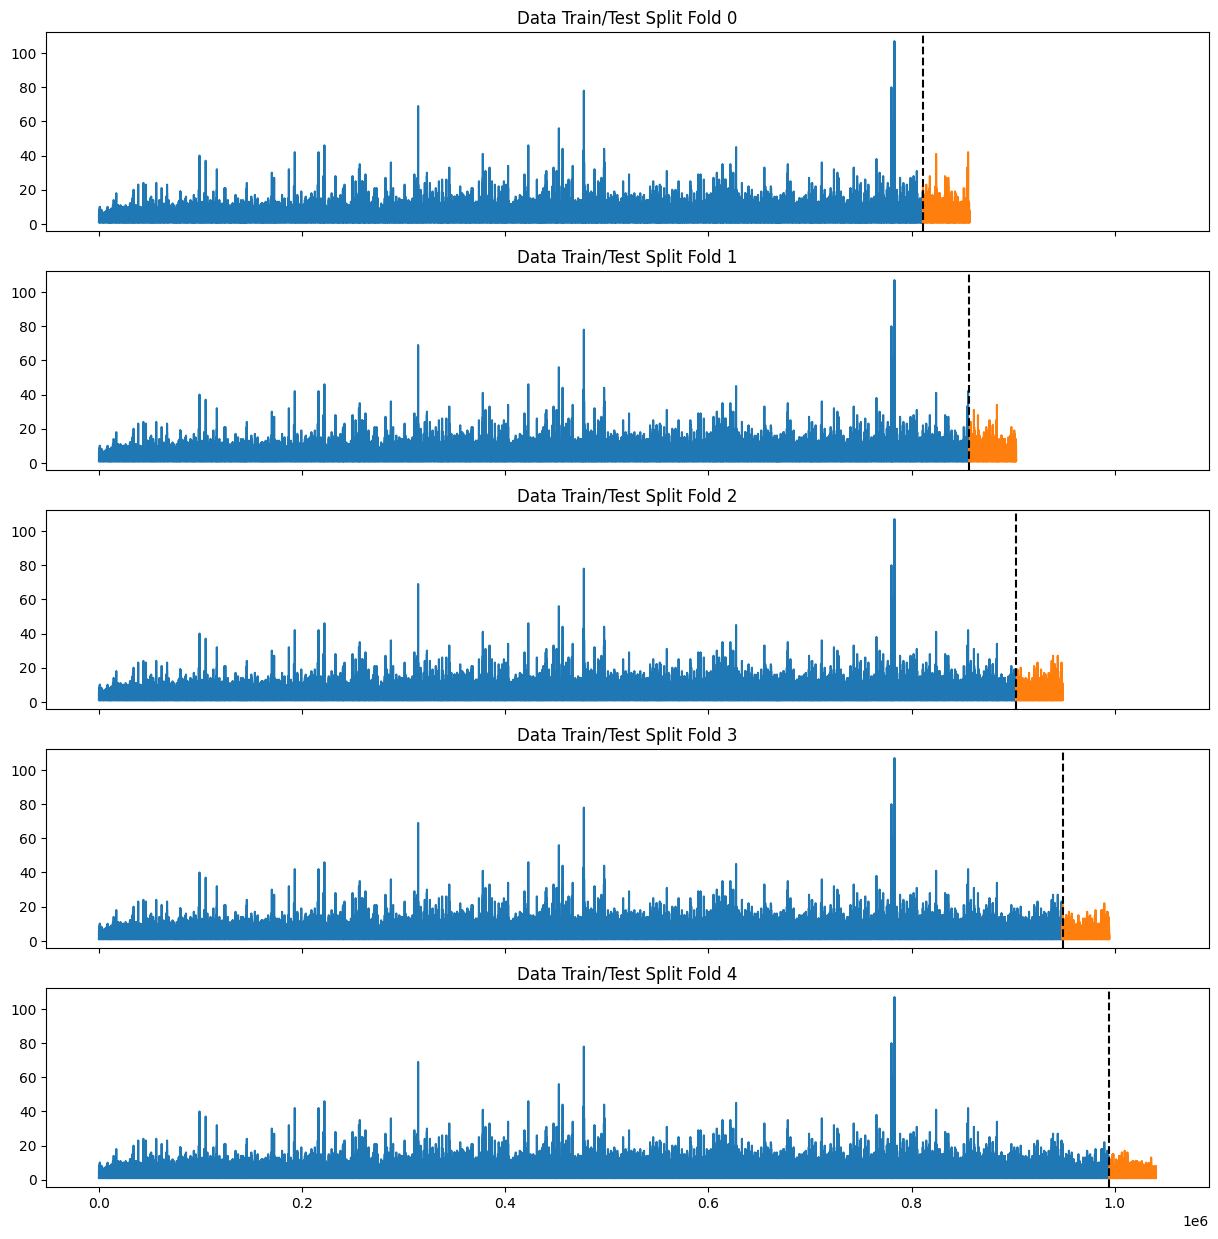

In [11]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [12]:
tss = TimeSeriesSplit(n_splits=5, test_size=46080, gap=24)
df = df.sort_index()

fold = 0
preds = pd.DataFrame()
rmse = []
mape = []
le = preprocessing.LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))
SCALER_FEATURES = ["start_time_year", "start_time_month", 
                   "start_time_day", "start_time_hour", 
                   "start_time_week", "start_time_quarter",
                   "start_time_dayofweek",
                   "temp", "dwpt", "rhum", "prcp", "wdir",
                   "wspd", "pres","coco",
                   "demand_lag_1_h", "demand_lag_2_h", 
                   "demand_lag_24_h", "temp_lag_1_h", 
                   "temp_lag_2_h", "temp_lag_24_h",
                   "prcp_lag_1_h", "prcp_lag_2_h",
                   "prcp_lag_24_h", "rhum_lag_1_h",
                   "rhum_lag_2_h", "rhum_lag_24_h", "wspd_lag_1_h", 
                   "wspd_lag_2_h","wspd_lag_24_h"]
target_scaler = MinMaxScaler(feature_range=(1, 2))
df[SCALER_FEATURES] = scaler.fit_transform(df[SCALER_FEATURES])
df[['demand']] = target_scaler.fit_transform(df[['demand']])
df['start_station_name'] = le.fit_transform(df['start_station_name'])
df['is_holiday'] = df['is_holiday'].astype(int)


In [13]:
24*5*df['start_station_name'].nunique()

45840

In [14]:
24*10*df['start_station_name'].nunique()

91680

In [15]:

for train_idx, val_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    FEATURES = ["start_station_name", 
                "start_time_year",
                "start_time_month",
                "start_time_day",
                "start_time_hour",
                "start_time_week",
                "start_time_quarter",
                "start_time_dayofweek",
                "is_holiday",
                "clusters",
                "temp",
                "dwpt",
                "rhum",
                "prcp",
                "wdir",
                "wspd",
                "pres",
                "coco",
                "demand_lag_1_h",
                "demand_lag_2_h",
                "demand_lag_24_h",
                "temp_lag_1_h",
                "temp_lag_2_h",
                "temp_lag_24_h",
                "prcp_lag_1_h",
                "prcp_lag_2_h",
                "prcp_lag_24_h",
                "rhum_lag_1_h",
                "rhum_lag_2_h",
                "rhum_lag_24_h",
                "wspd_lag_1_h",
                "wspd_lag_2_h",
                "wspd_lag_24_h"
                ]
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    preds_out = X_test.copy()
    preds_out['actual_demand'] = y_test
    preds_out['pred'] = y_pred
    preds = preds.append(preds_out)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)
    rmse.append(rmse_score)
    mape.append(mape_score)
    print(rmse_score)
    print(mape_score)
    print(preds.head())
    print(preds.tail())
    
print(f"Mean RMSE: {np.mean(rmse)}")
print(f"Mean MAPE: {np.mean(mape)}")
del df
del X_train
del y_train
del X_test

0.015237786206135143
0.010701601319640281
        start_station_name  start_time_year  start_time_month  start_time_day  \
809922                 263              1.0          1.818182             1.1   
809923                  25              1.0          1.818182             1.1   
809924                 120              1.0          1.818182             1.1   
809925                 350              1.0          1.818182             1.1   
809926                 106              1.0          1.818182             1.1   

        start_time_hour  start_time_week  start_time_quarter  \
809922         1.434783         1.764706                 2.0   
809923         1.434783         1.764706                 2.0   
809924         1.434783         1.764706                 2.0   
809925         1.434783         1.764706                 2.0   
809926         1.434783         1.764706                 2.0   

        start_time_dayofweek  is_holiday  clusters  ...  prcp_lag_2_h  \
809922       

0.013630215687265747
0.00980277240602766
        start_station_name  start_time_year  start_time_month  start_time_day  \
809922                 263              1.0          1.818182             1.1   
809923                  25              1.0          1.818182             1.1   
809924                 120              1.0          1.818182             1.1   
809925                 350              1.0          1.818182             1.1   
809926                 106              1.0          1.818182             1.1   

        start_time_hour  start_time_week  start_time_quarter  \
809922         1.434783         1.764706                 2.0   
809923         1.434783         1.764706                 2.0   
809924         1.434783         1.764706                 2.0   
809925         1.434783         1.764706                 2.0   
809926         1.434783         1.764706                 2.0   

        start_time_dayofweek  is_holiday  clusters  ...  prcp_lag_2_h  \
809922        

0.011382030615952813
0.00869983191191026
        start_station_name  start_time_year  start_time_month  start_time_day  \
809922                 263              1.0          1.818182             1.1   
809923                  25              1.0          1.818182             1.1   
809924                 120              1.0          1.818182             1.1   
809925                 350              1.0          1.818182             1.1   
809926                 106              1.0          1.818182             1.1   

        start_time_hour  start_time_week  start_time_quarter  \
809922         1.434783         1.764706                 2.0   
809923         1.434783         1.764706                 2.0   
809924         1.434783         1.764706                 2.0   
809925         1.434783         1.764706                 2.0   
809926         1.434783         1.764706                 2.0   

        start_time_dayofweek  is_holiday  clusters  ...  prcp_lag_2_h  \
809922        

In [16]:
suf = "_dec_2022_weather_lags_2022_only"

preds.to_csv(f"test_predictions{suf}.csv")
del preds
#
filename = f'demand_model{suf}.sav'
joblib.dump(reg, filename)
del reg

filename = f'target_scaler{suf}.sav'
joblib.dump(target_scaler, filename)
del target_scaler

filename = f'scaler{suf}.sav'
joblib.dump(scaler, filename)
del scaler

filename = f'label_encoder{suf}.sav'
joblib.dump(le, filename)
del le


In [17]:
#preds['demand'] = preds['actual_demand']
#preds[SCALER_FEATURES] = scaler.inverse_transform(preds[SCALER_FEATURES])